# SNODAS Wrapper

In [5]:
%matplotlib inline
import re
import os
import math
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from validation import SNODAS, MountainHub, Elevation, utils as ut
import regionmask
#import gdal
from osgeo import gdal
from datetime import datetime

## Downloading Data from SNODAS
Data can be fetched from SNODAS using the `snodas_ds(date)` function. It can then be saved using the appropriate function e.g. `save_netcdf(dataset, path)` or `save_tiff(dataset, path)`

In [2]:
def select_region(bb, snodas_ds):
    mask_region = regionmask.Regions([bb])
    mask_region_ = mask_region.mask(snodas_ds)
    sel_mask = mask_region_.where(mask_region_ == 0).values #np array
    lat = mask_region_.lat.values
    lon = mask_region_.lon.values
    id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
    id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
    out_sel = snodas_ds.sel(lat = slice(id_lat[0], id_lat[-1]), lon = slice(id_lon[0], 
                                                                    id_lon[-1])).compute().where(mask_region_ == 0)
    return out_sel
    

In [10]:
# Fetch data from SNODAS
start_date = datetime(2019,11,1)
for date in (start_date + timedelta(n) for n in range(31)):
    output_path = date.strftime('/Users/nicoleta/Desktop/data/SNODAS/SNODAS_%Y%m%d.nc')
    print(output_path)
    if not os.path.exists(output_path):
        snodas_ds = SNODAS.snodas_ds(date)
        ut.save_netcdf(snodas_ds, output_path)

/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191101.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191102.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191103.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191104.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191105.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191106.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191107.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191108.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191109.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191110.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191111.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191112.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191113.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191114.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191115.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191116.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191117.nc
/Users/nicoleta/Desktop/data/SNODAS/SNODAS_20191118.nc
/Users/nic

In [ ]:
# Fetch data from SNODAS

bb = np.array([[-108.565, 40.715], [-105.025, 40.715], [-105.025, 37.525], [-108.565, 37.525]])

from validation import SNODAS, MountainHub, Elevation, utils as ut

start_date = datetime(2013,10,1)

for date in (start_date + timedelta(n) for n in range(3193)):
    output_path = date.strftime('/Users/nicoleta/Desktop/data/SNODAS/SNODAS_%Y%m%d.nc')
    output_sel = date.strftime('/Users/nicoleta/Desktop/data/SNODAS/SNODAS_sel_%Y%m%d.nc')
    if not os.path.exists(output_path):
        try:
            snodas_ds = SNODAS.snodas_ds(date, code = 1034)
            ut.save_netcdf(snodas_ds, output_path)
            snodas_netcdf = xr.open_dataset(output_path)
            snodas_sel = select_region(bb, snodas_netcdf)
            snodas_sel.to_netcdf(output_sel)
            os.remove(output_path)
            os.rename(output_sel, output_path)
        except Exception as e:
            print("Error processing {}: {}".format(output_path, str(e)))

In [ ]:
snodas_sel

In [ ]:
#test
ds_test = xr.open_dataset('nicoleta/Desktop/data/snodas/SNODAS_20170914.nc')
bb = np.array([[-108.565, 40.715], [-105.025, 40.715], [-105.025, 37.525], [-108.565, 37.525]])
out_sel = select_region(bb, ds_test)
out_sel.Band1.plot()

In [ ]:
for y in range(2013, 2018):
    print(y)

## Merging files into single NetCDF files
Merging together NetCDF files for different dates can be accomplished by reading those files into xarray, and then writing the resulting dataset out to a new NetCDF file. It is important to set the proper coordinates along the time axis of the dataset before writing, in order to record the date of each individual layer. 

In [ ]:
# Get list of valid files
for year in range(2013, 2019):
    output_path = "/Users/carina/Desktop/data/seup/SNODAS_SWE/SNODAS_sel_{}.nc".format(year)
    print(output_path)
    if not os.path.exists(output_path):
        pattern = re.compile("^SNODAS_"+ str(year) + "\d{4}.nc$")
        # There's something wrong with SNODAS-20170913 - only use files after this for now
        files = sorted([os.path.join("/Users/carina/Desktop/data/seup/SNODAS_SWE",f) for f in os.listdir("/Users/carina/Desktop/data/seup/SNODAS_SWE") if pattern.match(f)])
        # Extract dates from files    
        dates = [ut.date_from_file(f) for f in files]

        ds = xr.open_mfdataset(files, concat_dim='time', autoclose=True)
        ds.coords['time'] = dates

        ds.to_netcdf(output_path)


# Only process if file does not already exist
#if not os.path.exists(output_path):
    # Get list of valid files
#    pattern = re.compile("^SNODAS_\d{8}.nc$")
    # There's something wrong with SNODAS-20170913 - only use files after this for now
#    files = sorted([os.path.join("/Users/carina/Desktop/data/seup/SNODAS_SWE",f) for f in os.listdir("/Users/carina/Desktop/data/seup/SNODAS_SWE") if pattern.match(f)])
    # Extract dates from files    
#    dates = [ut.date_from_file(f) for f in files]

#    ds = xr.open_mfdataset(files, concat_dim='time', autoclose=True)
#    ds.coords['time'] = dates

#    ds.to_netcdf(output_path)

In [ ]:
files

## Loading Merged Data in XArray
The merged dataset can then be reimported to xarray with the following function. The merging process is important, as it allows xarray to search the dataset much faster, opening up the possibility of API queries.

In [29]:
ds = []
for year in range(2013, 2019):
    output_path = "/Users/carina/Desktop/data/seup/SNODAS_SWE/SNODAS_sel_{}.nc".format(year)
    ds.append(xr.open_dataset(output_path))

In [35]:
ds


[<xarray.Dataset>
 Dimensions:  (lat: 383, lon: 425, time: 92)
 Coordinates:
   * lat      (lat) float64 37.53 37.54 37.55 37.55 37.56 37.57 37.58 37.59 ...
   * lon      (lon) float64 -108.6 -108.6 -108.5 -108.5 -108.5 -108.5 -108.5 ...
   * time     (time) datetime64[ns] 2013-10-01 2013-10-02 2013-10-03 ...
 Data variables:
     Band1    (time, lat, lon) float32 ...
     crs      (time, lat, lon) |S8 ...
 Attributes:
     Conventions:  CF-1.5
     GDAL:         GDAL 2.3.3, released 2018/12/14
     history:      Sun Aug 09 09:46:18 2020: GDAL Create( /Users/carina/Deskto...,
 <xarray.Dataset>
 Dimensions:  (lat: 383, lon: 425, time: 365)
 Coordinates:
   * lat      (lat) float64 37.53 37.54 37.55 37.55 37.56 37.57 37.58 37.59 ...
   * lon      (lon) float64 -108.6 -108.6 -108.5 -108.5 -108.5 -108.5 -108.5 ...
   * time     (time) datetime64[ns] 2014-01-01 2014-01-02 2014-01-03 ...
 Data variables:
     Band1    (time, lat, lon) float32 ...
     crs      (time, lat, lon) |S8 ...
 Attri

## Selecting snow depth across region
Data can be selected in a particular region by using the `sel` and `isel` functions in conjunction with `slice`, as shown below.

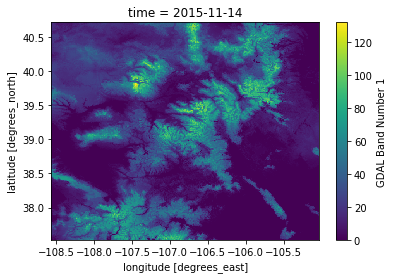

In [19]:
#ds.Band1.sel(time = '2017-9-14', lat = slice(40, 54), lon = slice(-126, -110)).plot()
ds.Band1.sel(time = '2015-11-14').plot()

## Selecting time series at location
A time series can be constructed as follows. It is important that the method parameter is set to `'nearest'` in order to recieve results.

In [ ]:
lat = 40.0018751
lon = -106.5

#region = {
#    'ymax' : 44.25,
#    'ymin' : 43.75,
#    'xmax': -121.65,
#    'xmin': -122.5,
#}

#obs = MountainHub.snow_data(limit=1000, start=datetime(2017,8,1), end=datetime(2018,3,28), box=region)
#obs = Elevation.merge_el_data(obs)

#plot = obs.plot(x='date', y='snow_depth', style='o')

snodas_series = ds.Band1.sel(lat=lat, lon=lon, method='nearest') / 100
#snodas_series.plot(ax=plot)
snodas_series.plot()

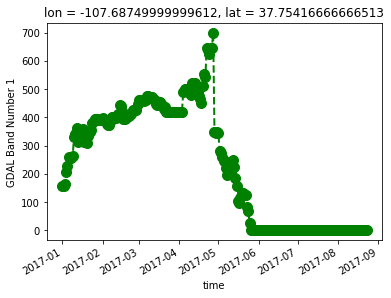

In [43]:
#temp = ds.sel(time = '2018-1-3', lon = -106, lat = 39.5, method='nearest').Band1.item()
#temp = ds[0].Band1.sel(lon = -107.6900, lat = 37.7500,  method='nearest')

ta = ds[4]['Band1']
ta_CBR = ta.sel(lat= 37.7500, lon = -107.6900, method = 'nearest')
ta_CBR.sel(time = slice('2013-10-01','2018-10-01')).plot(linestyle='dashed',color='g', linewidth=2, marker='o',markersize=10)

In [16]:
ta_CBR

<xarray.DataArray 'Band1' (time: 1827)>
array([nan, nan, nan, ...,  0.,  0.,  0.], dtype=float32)
Coordinates:
    lon      float64 -106.0
    lat      float64 39.5
  * time     (time) datetime64[ns] 2013-10-01 2013-10-02 2013-10-03 ...
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs

## Selecting point data at time and location
Data can be easily selected for a particular location and date. In the example below, snow depth is retrieved for January 3, 2018 near 44° N, 121.65° W.

In [ ]:
temp1

In [ ]:
ds.sel(time = '2018-1-3', lon = -121.65, lat = 44, method='nearest').Band1.item()

## Plotting Data Against SNODAS

In [ ]:
# Restrict points to the continental US
region = {
    'ymax' : 50,
    'ymin' : 25,
    'xmax': -65,
    'xmin': -125,
}

obs = MountainHub.snow_data(limit=1000, start=datetime(2017,9,14), end=datetime(2018,3,28), box=region)
def snodas_depth(ts, lon, lat):
    height = ds.Band1.sel(time = ts.strftime('%Y-%m-%d'), lon=lon, lat=lat, method='nearest').item()
    if not np.isnan(height):
        height /= 10
    return height

obs['snodas_depth'] = obs.apply(lambda x: snodas_depth(x['date'], x['long'], x['lat']), axis=1)

sns.set(color_codes=True)
sns.lmplot(x='snodas_depth',y='snow_depth',data=obs, fit_reg=True, lowess=True) 